In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.3.1.post3'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 256

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [45]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [46]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [47]:
np.max(train_dataset_labelled)

255

In [48]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [49]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**WAE-WGAN**

In [11]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [12]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [100]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2] # [3 x 32 x 32]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 4, padding=2, stride=2), # [32 x 17 x 17]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 5, padding=2, stride=2), # [64 x 9 x 9]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, padding=2, stride=2), # [128 x 5 x 5]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 3 x 3]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 2 x 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, 1), # [512 x 2 x 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, output_dim, 2) # [output_dim x 1 x 1]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(means=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [79]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, hidden_count=4):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            ReshapeLayer(-1),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2)
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.LeakyReLU(negative_slope=0.2))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [109]:
class WAE_WGAN(nn.Module):
    def __init__(self, input_shape, latent_dim, 
                 regularization_factor=10, lipschitz_constraint_factor=2):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.regularization_factor = regularization_factor
        self.lipschitz_constraint_factor = lipschitz_constraint_factor
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        self.proposal_discriminator = Discriminator(latent_dim * 1 * 1)
        
        self.generative_network = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 2), # [512 x 2 x 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 3 x 3]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 5, padding=2, stride=2), # [128 x 5 x 5]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5, padding=2, stride=2), # [64 x 9 x 9]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 5, padding=2, stride=2), # [32 x 17 x 17]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 32, 4, padding=2, stride=2), # [32 x 32 x 32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 1), # [32 x 32 x 32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, input_shape[0], 1), # [3 x 32 x 32]
            nn.Sigmoid()
        )

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim, 1, 1)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim, 1, 1)))
        return mu, sigma

    def sample_latent(self, X):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        return self.proposal_generator(X)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        return self.generative_network(z)

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        zs = self.sample_latent(batch)
        zs_prior = self.sample_prior(n)
        batch_rec = self.generative_distr(zs)
        #reconstruction_loss = torch.sum((batch_rec - batch) ** 2) / n
        reconstruction_loss = torch.sum(torch.abs(batch_rec - batch)) / n
        #reconstruction_loss = torch.sum(binary_crossentropy_loss(batch.view(n, -1), batch_rec.view(n, -1))) / n
        discriminator_loss = torch.mean(self.proposal_discriminator(zs_prior) - self.proposal_discriminator(zs))
        eps = cuda_wrapper(torch.rand(n, 1, 1, 1))
        zs_hat = Variable(zs_prior.data * eps + zs.data * (1 - eps), requires_grad=True)
        value_hat = self.proposal_discriminator(zs_hat)
        value_hat_grad_sqr_norm = torch.sum(
            autograd.grad([torch.sum(value_hat)], [zs_hat], create_graph=True)[0].view(n, -1) ** 2, dim=-1
        )
        lipschitz_loss = torch.mean((torch.sqrt(value_hat_grad_sqr_norm) - 1) ** 2)
        return reconstruction_loss - discriminator_loss * self.regularization_factor,\
               (discriminator_loss + lipschitz_loss * self.lipschitz_constraint_factor) * self.regularization_factor

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.generative_distr(self.sample_prior(num_samples))

In [21]:
def batch_generator(data, labels, batch_size):
    assert data.shape[0] == labels.shape[0]
    data_size = data.shape[0]
    indices = np.random.permutation(data_size)
    for i in range(0, data_size, batch_size):
        if i+batch_size > data_size:
            yield torch.from_numpy(data[indices[i:]] / 256).float(), torch.from_numpy(labels[indices[i:]])
        else:
            yield (
                torch.from_numpy(data[indices[i:i+batch_size]] / 256).float(), 
                torch.from_numpy(labels[indices[i:i+batch_size]])
            )

In [22]:
def batch_generator_same_labels(data, labels, batch_size, num_labels=10):
    assert data.shape[0] == labels.shape[0]
    for label in np.random.permutation(num_labels):
        batch_gen = batch_generator(data[labels == label], labels[labels == label], batch_size)
        for X, _ in batch_gen:
            yield X, label

Epoch 1 of 100 took 14.49s;
train loss: 480.82; test loss: 417.44
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 2 of 100 took 14.54s;
train loss: 370.38; test loss: 328.75
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 3 of 100 took 14.52s;
train loss: 310.31; test loss: 301.23
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 4 of 100 took 14.51s;
train loss: 289.13; test loss: 285.16
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 5 of 100 took 14.55s;
train loss: 277.09; test loss: 275.99
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


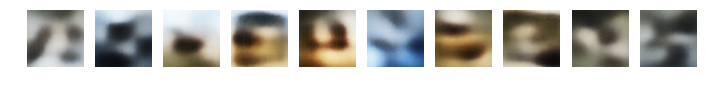

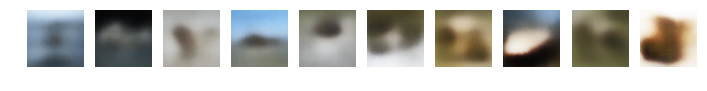

Epoch 6 of 100 took 14.61s;
train loss: 270.52; test loss: 270.22
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 7 of 100 took 14.55s;
train loss: 265.38; test loss: 267.34
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 8 of 100 took 14.53s;
train loss: 259.11; test loss: 260.21
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 9 of 100 took 14.51s;
train loss: 251.53; test loss: 251.76
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 10 of 100 took 14.59s;
train loss: 246.08; test loss: 244.72
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


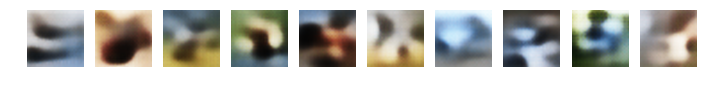

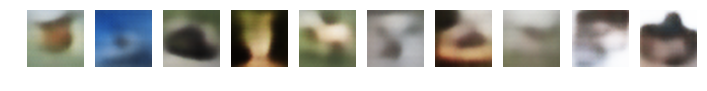

Epoch 11 of 100 took 14.53s;
train loss: 241.16; test loss: 243.58
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 12 of 100 took 14.56s;
train loss: 238.65; test loss: 240.59
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 13 of 100 took 14.49s;
train loss: 233.76; test loss: 235.15
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 14 of 100 took 14.38s;
train loss: 229.45; test loss: 232.67
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 15 of 100 took 14.39s;
train loss: 227.22; test loss: 231.18
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


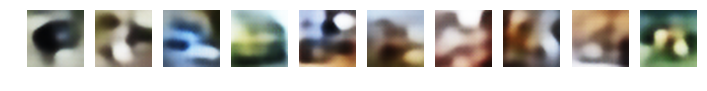

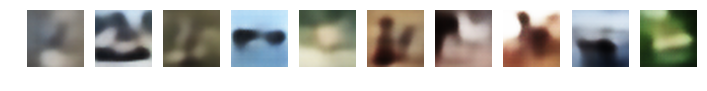

Epoch 16 of 100 took 14.38s;
train loss: 224.65; test loss: 228.82
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 17 of 100 took 14.45s;
train loss: 222.95; test loss: 226.31
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 18 of 100 took 14.40s;
train loss: 221.02; test loss: 225.18
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 19 of 100 took 14.49s;
train loss: 219.45; test loss: 223.33
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 20 of 100 took 14.42s;
train loss: 217.00; test loss: 221.81
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


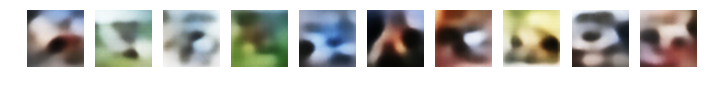

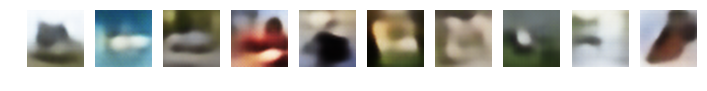

Epoch 21 of 100 took 14.47s;
train loss: 215.33; test loss: 219.56
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 22 of 100 took 14.56s;
train loss: 213.37; test loss: 219.38
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 23 of 100 took 14.45s;
train loss: 211.56; test loss: 217.12
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 24 of 100 took 14.36s;
train loss: 210.14; test loss: 216.10
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 25 of 100 took 14.45s;
train loss: 208.88; test loss: 215.18
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


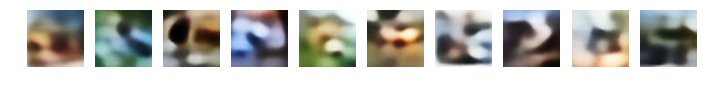

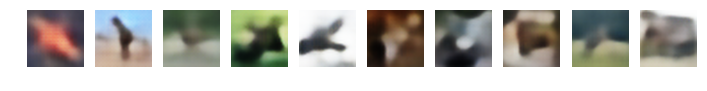

Epoch 26 of 100 took 14.61s;
train loss: 207.71; test loss: 215.18
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 27 of 100 took 14.85s;
train loss: 205.94; test loss: 213.80
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 28 of 100 took 14.60s;
train loss: 204.82; test loss: 213.70
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 29 of 100 took 14.56s;
train loss: 204.20; test loss: 213.05
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 30 of 100 took 14.49s;
train loss: 202.97; test loss: 210.16
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


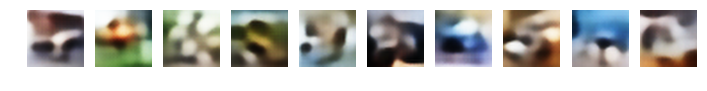

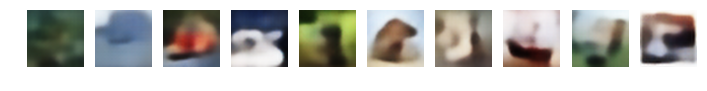

Epoch 31 of 100 took 14.48s;
train loss: 202.24; test loss: 210.13
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 32 of 100 took 14.43s;
train loss: 201.38; test loss: 210.33
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 33 of 100 took 14.53s;
train loss: 200.44; test loss: 208.60
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 34 of 100 took 14.46s;
train loss: 199.45; test loss: 207.24
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00
Epoch 35 of 100 took 14.42s;
train loss: 198.03; test loss: 205.27
train discriminator loss: 0.00; test discriminator loss: 0.00
reg factor: 0.00


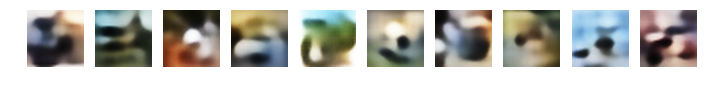

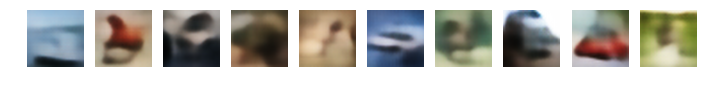

Process Process-26498:
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


KeyboardInterrupt: 

  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


In [110]:
latent_dim = 64

num_epochs = 100
save_every = 100

name_prefix = 'wae_gan_results/'

#try:
if True:
    #vae = cuda_wrapper(VAE(latent_dim, input_shape))
    #vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
    #print("Found pretrained VAE")
#except:
    #print("Didn't found pretrained VAE; training...")
    
    wae = cuda_wrapper(WAE_WGAN(input_shape, latent_dim, regularization_factor=0))
    optimizer = optim.Adam(
        list(wae.proposal_generator.parameters()) + list(wae.generative_network.parameters()), 
        lr=3e-4, betas=(0.9, 0.9)
    )
    optimizer_discriminator = optim.Adam(wae.proposal_discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        start_time = time()
        
        #wae.regularization_factor = np.clip((epoch - 200) / 10, 0, 100)
        wae.regularization_factor = 0
        
        cum_loss = 0
        cum_loss_discriminator = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = cuda_wrapper(Variable(X_batch))

            loss, loss_discriminator = wae.batch_loss(X_batch)
            cum_loss += loss.data[0]
            cum_loss_discriminator += loss_discriminator.data[0]
        
            do_discriminator_update = (
                epoch * len(train_loader.dataset.train_labels) // X_batch.shape[0] + batch_count
            ) % 1 > 0
        
            if do_discriminator_update:
                optimizer_discriminator.zero_grad()
                loss_discriminator.backward()
                optimizer_discriminator.step()
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            batch_count += 1
    
        mean_train_loss = cum_loss / batch_count
        mean_train_loss_discriminator = cum_loss_discriminator / batch_count

        cum_loss = 0
        cum_loss_discriminator = 0
        batch_count = 0
        
        for X_batch, _ in test_loader:
            X_batch = cuda_wrapper(Variable(X_batch))

            loss, loss_discriminator = wae.batch_loss(X_batch)
            cum_loss += loss.data[0]
            cum_loss_discriminator += loss_discriminator.data[0]
        
            batch_count += 1
            
        mean_test_loss = cum_loss / batch_count
        mean_test_loss_discriminator = cum_loss_discriminator / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss: {:.2f}; test loss: {:.2f}'.format(mean_train_loss, mean_test_loss))
        print('train discriminator loss: {:.2f}; test discriminator loss: {:.2f}'.format(
            mean_train_loss_discriminator, mean_test_loss_discriminator
        ))
        print('reg factor: {:.2f}'.format(wae.regularization_factor))
        
        if (epoch+1) % 5 == 0:
            show_images(wae.generate_samples(10))
            plt.show()
            show_images(
                wae.generative_network(
                    wae.proposal_generator(
                        cuda_wrapper(Variable(next(iter(train_loader))[0][:10]))
                    )
                )
            )
            plt.show()
    
        #if (epoch+1) % save_every == 0:
        #    torch.save(wae.state_dict(), name_prefix + 'wae_gan.pt')
        
    print()


In [17]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].cpu().numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

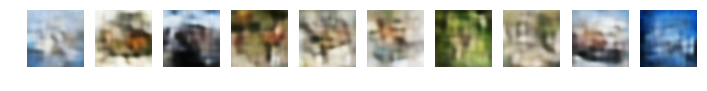

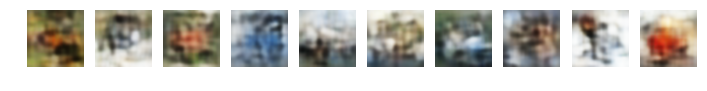

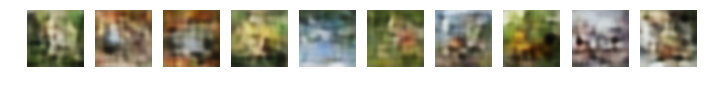

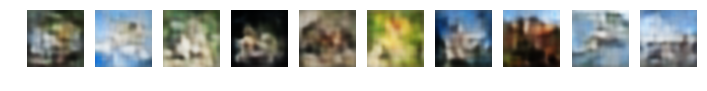

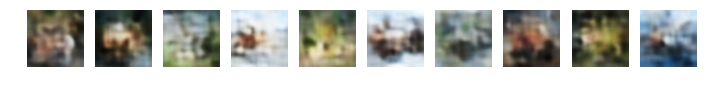

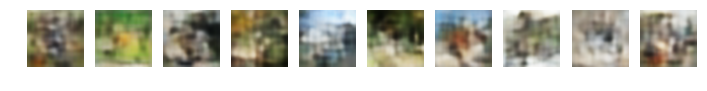

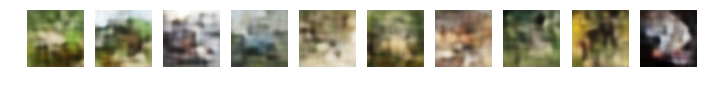

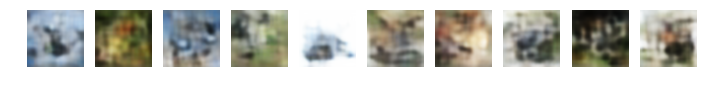

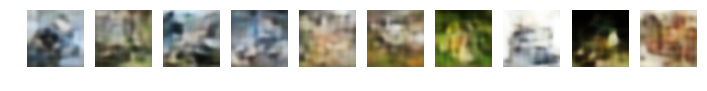

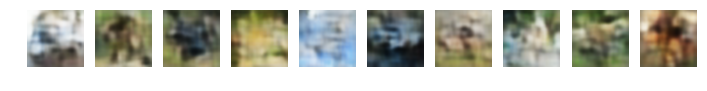

In [40]:
for label in range(10):
    show_images(wae.generate_samples(10))
    plt.show()

**Tangent prop**

In [41]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = cuda_wrapper(
                Variable(torch.normal(std=torch.ones(batch_size, latent_dim)))
            ) # [batch_size x latent_dim]
            X_gen = Variable(generative_model.generative_distr(z_gen).data, requires_grad=True) # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = cuda_wrapper(Variable(X_gen, requires_grad=True))
        z_inferred = generative_model.sample_latent(X_gen) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = cuda_wrapper(
                Variable(torch.normal(std=torch.ones(batch_size, latent_dim)), requires_grad=True)
            ) # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = cuda_wrapper(Variable(X))
            z_inferred = cuda_wrapper(
                Variable(generative_model.sample_latent(X).data, requires_grad=True)
            ) # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [42]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [43]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [63]:
num_epochs = 100
save_every = 20

modes = ['tangent_prop_reparam_invariant_stochastic_eta=' + str(eta) for eta in [0, 1e-3, 1e-2, 1e-1]]

loss_function = nn.NLLLoss()

for mode in modes[2:]:
    mode_name = mode + '_labelled=4000_epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    model = cuda_wrapper(ModelConvolutional(input_shape, output_size))
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
    
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_loss_full = 0
        cum_acc = 0
        batch_count = 0

        model.train()
        for X, y in train_loader_labelled:
            X, y = cuda_wrapper(Variable(X)), cuda_wrapper(Variable(y))
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.data[0]
        
            #X_random = cuda_wrapper(Variable(next(random_input_gen), requires_grad=True))
            #loss_constrain = constrain_loss_function(model(X_random), X_random)
            if mode == 'no_reg':
                loss_constrain = cuda_wrapper(Variable(torch.zeros(1)))
            elif mode == 'tangent_prop':
                loss_constrain = constrain_loss_function(model, wae, reparam_invariant=False, use_all_classes=True)
            elif mode.startswith('tangent_prop_reparam_invariant_stochastic'):
                loss_constrain = constrain_loss_function(model, wae, reparam_invariant=True, use_all_classes=False)
            else:
                raise NotImplementedError
            cum_loss_constrain += loss_constrain.data[0]
        
            loss_full = loss_data + eta * loss_constrain
            cum_loss_full += loss_full.data[0]
            
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.data[0]
        
            optimizer.zero_grad()
            loss_full.backward()
            optimizer.step()
            batch_count += 1
            
        mean_train_loss_data = cum_loss_data / batch_count
        mean_train_loss_constrain = cum_loss_constrain / batch_count
        mean_train_loss_full = cum_loss_full / batch_count
        mean_train_acc = cum_acc / batch_count

        train_losses[mode].append(mean_train_loss_data)
        train_accs[mode].append(mean_train_acc)
        
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_acc = 0
        batch_count = 0

        model.eval()
        for X, y in test_loader:
            X, y = cuda_wrapper(Variable(X)), cuda_wrapper(Variable(y))
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.data[0]
        
            #if mode == 'no_reg':
            #    loss_constrain = cuda_wrapper(Variable(torch.zeros(1)))
            #elif mode == 'tangent_prop':
            #    loss_constrain = constrain_loss_function(model, vae, reparam_invariant=False, use_all_classes=True)
            #elif mode == 'tangent_prop_reparam_invariant_stochastic':
            #    loss_constrain = constrain_loss_function(model, vae, reparam_invariant=True, use_all_classes=False)
            #else:
            #    raise NotImplementedError
            #cum_loss_constrain += loss_constrain.data[0]
        
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.data[0]
        
            batch_count += 1
            
        mean_test_loss_data = cum_loss_data / batch_count
        mean_test_loss_constrain = cum_loss_constrain / batch_count
        mean_test_acc = cum_acc / batch_count

        test_losses[mode].append(mean_test_loss_data)
        test_accs[mode].append(mean_test_acc)
        
        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
            )
        )
        print('train acc: {:.2f}'.format(mean_train_acc))
        print('test loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}'.format(
                mean_test_loss_data, mean_test_loss_constrain
            )
        )
        print('test acc: {:.2f}'.format(mean_test_acc))
        print()
        
        if (epoch+1) % save_every == 0:
            with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                pickle.dump(np.array(train_losses[mode]), f)
            with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                pickle.dump(np.array(test_losses[mode]), f)
            with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                pickle.dump(np.array(train_accs[mode]), f)
            with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                pickle.dump(np.array(test_accs[mode]), f)

            torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')



Mode: tangent_prop_reparam_invariant_stochastic_eta=0.01
tangent_prop_reparam_invariant_stochastic_eta=0.01_labelled=4000_epochs=100
eta = 0.01

Epoch 1 of 100 took 13.19s;
train loss:
data term: 2.10, constrain term: 0.09, full: 2.10
train acc: 0.24
test loss:
data term: 2.38, constrain term: 0.00
test acc: 0.10

Epoch 2 of 100 took 13.11s;
train loss:
data term: 1.91, constrain term: 0.50, full: 1.92
train acc: 0.32
test loss:
data term: 2.27, constrain term: 0.00
test acc: 0.21

Epoch 3 of 100 took 13.11s;
train loss:
data term: 1.82, constrain term: 0.99, full: 1.83
train acc: 0.34
test loss:
data term: 2.18, constrain term: 0.00
test acc: 0.23

Epoch 4 of 100 took 13.12s;
train loss:
data term: 1.75, constrain term: 1.53, full: 1.77
train acc: 0.38
test loss:
data term: 2.15, constrain term: 0.00
test acc: 0.24

Epoch 5 of 100 took 13.12s;
train loss:
data term: 1.71, constrain term: 1.98, full: 1.73
train acc: 0.38
test loss:
data term: 2.08, constrain term: 0.00
test acc: 0.25



Epoch 48 of 100 took 13.10s;
train loss:
data term: 0.91, constrain term: 2.81, full: 0.94
train acc: 0.72
test loss:
data term: 1.50, constrain term: 0.00
test acc: 0.49

Epoch 49 of 100 took 13.11s;
train loss:
data term: 0.89, constrain term: 2.75, full: 0.92
train acc: 0.72
test loss:
data term: 1.44, constrain term: 0.00
test acc: 0.50

Epoch 50 of 100 took 13.11s;
train loss:
data term: 0.90, constrain term: 2.89, full: 0.92
train acc: 0.72
test loss:
data term: 1.57, constrain term: 0.00
test acc: 0.45

Epoch 51 of 100 took 13.11s;
train loss:
data term: 0.89, constrain term: 3.00, full: 0.92
train acc: 0.72
test loss:
data term: 1.34, constrain term: 0.00
test acc: 0.55

Epoch 52 of 100 took 13.10s;
train loss:
data term: 0.84, constrain term: 2.36, full: 0.87
train acc: 0.74
test loss:
data term: 1.33, constrain term: 0.00
test acc: 0.55

Epoch 53 of 100 took 13.10s;
train loss:
data term: 0.82, constrain term: 2.29, full: 0.85
train acc: 0.75
test loss:
data term: 1.43, const

Epoch 96 of 100 took 13.11s;
train loss:
data term: 0.29, constrain term: 0.79, full: 0.30
train acc: 0.93
test loss:
data term: 1.37, constrain term: 0.00
test acc: 0.57

Epoch 97 of 100 took 13.13s;
train loss:
data term: 0.29, constrain term: 0.80, full: 0.30
train acc: 0.93
test loss:
data term: 1.47, constrain term: 0.00
test acc: 0.55

Epoch 98 of 100 took 13.22s;
train loss:
data term: 0.28, constrain term: 0.82, full: 0.29
train acc: 0.93
test loss:
data term: 1.36, constrain term: 0.00
test acc: 0.61

Epoch 99 of 100 took 13.11s;
train loss:
data term: 0.27, constrain term: 0.80, full: 0.28
train acc: 0.93
test loss:
data term: 1.35, constrain term: 0.00
test acc: 0.60

Epoch 100 of 100 took 13.11s;
train loss:
data term: 0.27, constrain term: 0.75, full: 0.27
train acc: 0.94
test loss:
data term: 1.39, constrain term: 0.00
test acc: 0.58

Mode: tangent_prop_reparam_invariant_stochastic_eta=0.1
tangent_prop_reparam_invariant_stochastic_eta=0.1_labelled=4000_epochs=100
eta = 0.

Process Process-24939:
Traceback (most recent call last):
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Ex

KeyboardInterrupt: 

In [57]:
from pandas import ewma, DataFrame

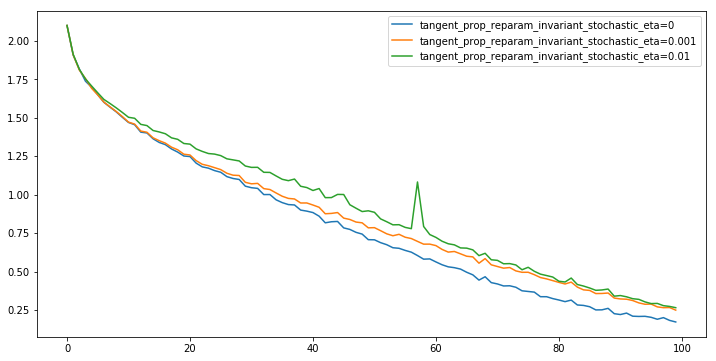

In [65]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_losses[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


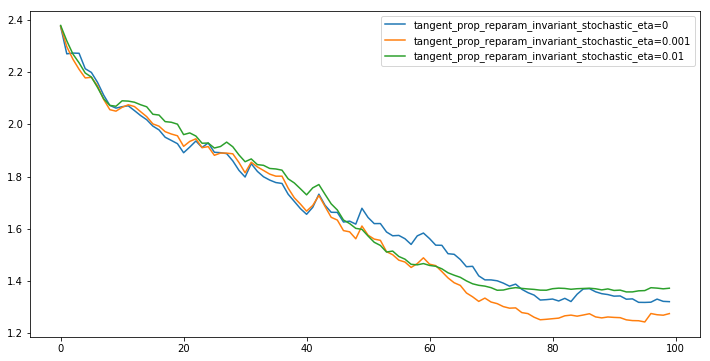

In [66]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_losses[mode]), alpha=0.1))
plt.legend(modes)

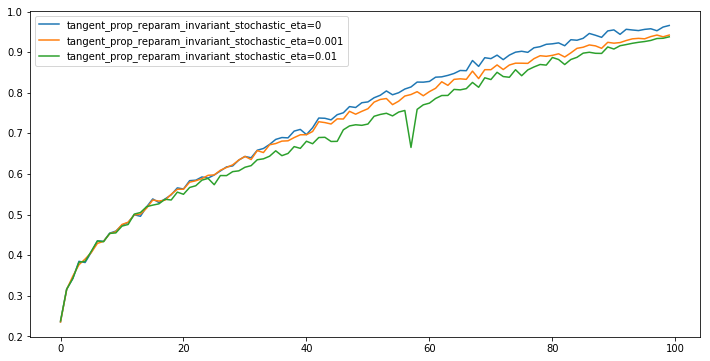

In [67]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_accs[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


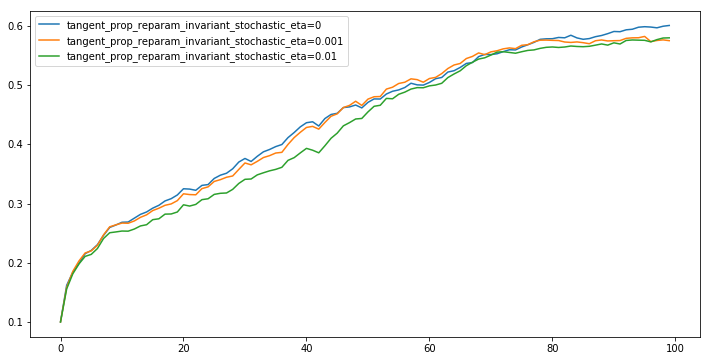

In [68]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_accs[mode]), alpha=0.1))
plt.legend(modes)